In [42]:
# Configuration
geneticCode=11 # Bacterial
windowWidth=40
cdsSpan=100
utrSpan=100
randomizationDepth=10
sequenceSamplingFraction=15
cdsSeqsFilename = 'rts_export_taxid_511145_cds.fna'
utrSeqsFilename = 'rts_export_taxid_511145_3utr.fna'

In [29]:
import numpy  as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from codon_randomization import SynonymousCodonPermutingRandomization, NucleotidePermutationRandomization
from rnafold_vienna import RNAfold_direct


cdsRand = SynonymousCodonPermutingRandomization(geneticCode=geneticCode)
utrRand = NucleotidePermutationRandomization()


def getCDSandUTRseqs(cdsfn, utrfn):
    cdsrecs = SeqIO.parse(cdsfn, "fasta", alphabet=IUPAC.unambiguous_dna)
    utrrecs = SeqIO.parse(utrfn, "fasta", alphabet=IUPAC.unambiguous_dna)
    
    for a, b in zip(cdsrecs, utrrecs):
        yield (str(a.seq), str(b.seq))
        

def makeRandomizationsForCDSand3UTR(cdsSeq, utrSeq):
    while(True):
        yield (cdsRand.randomize(cdsSeq), utrRand.randomize(utrSeq))


def getAllWindows( cdsSeq, utrSeq, windowWidth=40, cdsSpan=100, utrSpan=100):
    cdsExpectedLength = cdsSpan
    utrExpectedLength = utrSpan+windowWidth
    cdsRegion = cdsSeq[-cdsExpectedLength:                 ]
    utrRegion = utrSeq[                  :utrExpectedLength]
    if len(utrRegion)<windowWidth:
        utrRegion = utrRegion + 'N'*(windowWidth-len(utrRegion))
    
    cdsPadding = 0
    if len(cdsRegion) < cdsExpectedLength:
        cdsPadding = cdsExpectedLength - len(cdsRegion)
    assert(cdsPadding + len(cdsRegion) == cdsExpectedLength)
    
    utrPadding = 0
    if len(utrRegion) < utrExpectedLength:
        utrPadding = utrExpectedLength - len(utrRegion)
    assert(utrPadding + len(utrRegion) == utrExpectedLength)
    
    #fullRegion = cdsRegion[-cdsSpan:] + utrRegion[:(utrSpan+windowWidth)]
    fullRegion = cdsRegion + utrRegion
    #print(len(cdsSeq), len(utrSeq))
    #print(cdsPadding, len(fullRegion), utrPadding)

    # Padding for CDS
    for i in range(cdsPadding):
        yield None
            
    # Windows for CDS and UTR
    for i in range(len(fullRegion)-windowWidth):
        yield fullRegion[i:i+windowWidth]
    
    # Padding for UTR
    for i in range(utrPadding):
        yield None


def getLFEforAllWindows(cdsSeq, utrSeq, windowWidth, cdsSpan, utrSpan):
    for seqToFold in getAllWindows( cdsSeq, utrSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
        if( seqToFold is None ): # padding
            yield( np.NAN)
            continue

        assert(len(seqToFold)==windowWidth)
        LFE = RNAfold_direct( seqToFold )
        yield LFE


In [43]:
allNativeLFEs = []
allRandomLFEs = []
allDeltaLFEs  = []

for n, seqs in enumerate(getCDSandUTRseqs( cdsSeqsFilename, utrSeqsFilename)): #[(cdsSeq1, utrSeq1), (cdsSeq1, utrSeq1), (cdsSeq1, utrSeq1)]:
    cdsSeq, utrSeq = seqs
    #print(len(cdsSeq))
    #print(len(utrSeq))
    #print(cdsSeq)
    
    if n%sequenceSamplingFraction != 0: continue   # sample a fraction of the sequences (to speed up testing)
    if len(cdsSeq) < 150: continue
    #if len(utrSeq) <  80: continue
    
    #print("cds: {} utr: {}".format(len(cdsSeq), len(utrSeq)))
    
    # Calculate native LFE profile
    LFEs = []
    for LFE in getLFEforAllWindows( cdsSeq, utrSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
        LFEs.append(LFE)
    #print(len(LFEs))
    assert( len(LFEs) == cdsSpan+utrSpan )
    nativeLFE = np.expand_dims( np.array(LFEs), axis=0 )
    allNativeLFEs.append(nativeLFE)

    # Calculate randomized LFE profile
    randomLFEs = []
    for n, randSeqs in enumerate( makeRandomizationsForCDSand3UTR( cdsSeq, utrSeq)):
        randCDSresult, randUTRresult = randSeqs
        randCDS = randCDSresult[2]
        randUTR = randUTRresult[2]
        #print((randCDS, randUTR))

        LFEs = []
        for LFE in getLFEforAllWindows( randCDS, randUTR, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
            LFEs.append(LFE)
        assert(len(LFEs)==cdsSpan+utrSpan)
        randomLFEs.append( np.array(LFEs) )
        if n>=randomizationDepth-1: break
    randomLFEs = np.vstack(randomLFEs)
    
    allRandomLFEs.append(randomLFEs.mean(axis=0))
        
    # Calculate delta-LFE profile
    dLFE = (nativeLFE - randomLFEs).mean(axis=0)
    allDeltaLFEs.append(dLFE)
        
    if len(allDeltaLFEs) % 20 == 19:
        print("(completed {} sequences)".format(len(allDeltaLFEs)))


600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
600 107
0 207 33
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1152 100
0 200 40
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
1242 243
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
246 286
0 240 0
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
450 60
0 160 80
1416 90
0 190 50
1416 90
0 190 50
1416 90
0 190 50
1416 90
0 190 50
1416 90


[272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272
 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272
 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272
 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272
 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272 272
 272 272 272 272 272 272 272 272 272 272 145 142 140 137 137 136 136 135
 134 132 130 127 126 126 125 125 124 124 123 123 122 122 120 120 119 117
 115 115 114 114 113 113 113 111 110 109 109 109 108 107 106 105 104 104
 103 101 100 100 100  99  97  96  96  96  95  94  94  93  93  91  89  87
  87  87  85  83  82  81  80  80  78  78  78  78  77  76  76  74  74  73
  73  73  73  73  73  72  72  72  72  72  72  71  71  70  70  70  70  67
  65  64]


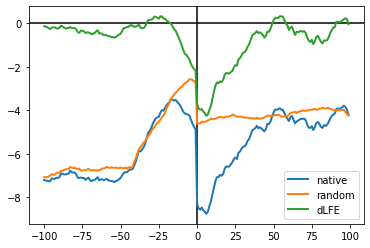

In [44]:
import matplotlib.pyplot as plt

nativeLFEprofile = np.nanmean( np.vstack(allNativeLFEs), axis=0)
randomLFEprofile = np.nanmean( np.vstack(allRandomLFEs), axis=0)
deltaLFEprofile  = np.nanmean( np.vstack(allDeltaLFEs),  axis=0)

plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.plot(range(-100,100), nativeLFEprofile, lw=2, label='native')
plt.plot(range(-100,100), randomLFEprofile, lw=2, label='random')
plt.plot(range(-100,100), deltaLFEprofile,  lw=2, label='dLFE')
plt.legend();

print((~np.isnan(np.vstack(allNativeLFEs))).sum(axis=0))
#print(np.nanmean( np.vstack(allNativeLFEs), axis=0 ))

In [45]:
Tests = ( ('test1',
           'agtggctcaacagtggtaacactggaagcacccgctacttaccacacctccgacagtggtaacacgctgatttatactgggctcaacgcgactcttttgggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcgggggtggaggcgggggatta',
           'ccactacgacgactgcgctacgatcgcctcgtaagatctacccagatccgacccgaccgcgctagccaacacgatcccggatggacggctcgctaggcatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctcac'),
          ('test2',
           'agtggctcaacagtggtaacactggaagcacccgctacttaccacactccgacagtggtaacacgctgatcctccgacagcttggtaacacgctgatttatctccgccgacagtggtaacacctccgtggtaacacgctggtaacacgctgatttatctccgtgatttatctccgacagtggtaacacgctgatgctgattggtaacacgctgatttatctccgacagtggttggtaacacgctgatttatctccgaacacgctgatactgggctcaacgcgactcttttgggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcgggggtggaggcgggggatta',
           '')
        )

for testName, cdsSeq, utrSeq in Tests:
    values = list(getAllWindows( cdsSeq, utrSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan))


171 153
0 240 0
363 0
0 140 100
